In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import sklearn.linear_model
import scipy.stats

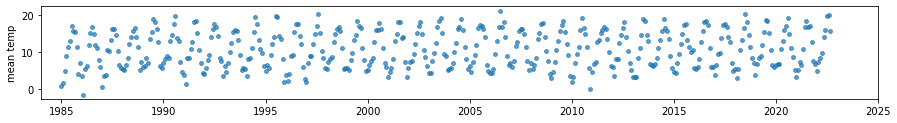

In [2]:
# Load the dataset
url = 'https://www.cl.cam.ac.uk/teaching/2223/DataSci/data/climate.csv'
climate = pandas.read_csv(url)
climate = climate.loc[(climate.station=='Cambridge') & (climate.yyyy>=1985)].copy()
t = climate.yyyy + (climate.mm-1)/12
temp = (climate.tmin + climate.tmax)/2

fig,ax = plt.subplots(figsize=(15,1.7))
ax.scatter(t, temp, s=15, alpha=0.7)
ax.set_xlim([1984, 2025])
ax.set_ylabel('mean temp')
plt.show()

In line with the Bayesianist approach, I treat each of the unknown variables - $\alpha$, $\beta_1$, $\beta_2$, $\gamma$, and $\sigma$ - as a random variable. Let's call the random variables $A, B1, B2, C, S$ respectively. 

The challenge is now inventing prior distributions for each of these variables.

_Digression (I'm thinking aloud here, so the prose is somewhat narrative):_ I think what's interesting is that this analysis assumes the linear model is correct. But all models are incorrect. Perhaps you can use the Bayesianist philosophy to choose a model. Let's say you have n models. You can invent a categorical random variable that describes your beliefs about how correct the models are. You can then use computational bayes to compute the posterior and then maybe pick the mode. Or maybe it'd lead you to some combination of the models, like Question 6 of example sheet 2. I wonder how this would fit in with parameter "fitting". Since you'd need the parameters to define the model, you'd probably do that first. 

Back to the problem. 

Assume this linear model is correct, and all that is unknown are the parameters. Eyeballing the data, it looks like the average temperature in 2000 is around 10 degrees. I'll pick a normal distrbution centred at 10 degrees, with a standard deviation of 1 (somewhat guesswork). The amplitude of the sinusoid is roughly 10, so I'm going to pick uniform distributions for $\beta_1$ and $\beta_2$ between -12 and 12 (to give myself some room for error). 

For $\gamma$, looking back at the code for challenge one and the slides, it seems like the average increase between 1960 and 2020 is around 0.03 degrees a year. This is obviously subjective, but my hypothesis is that the probability is not uniform, but the likelihood of temperature rise being 0.03 is greater than say -5. I'll choose a normal distribution centred at 0.03. As for the standard deviation, I'm bearing in mind that most of the probability mass will be distributed within 3 standard deviations of the mean. I don't want to rule out the possibility of no warming, or cooling, so standard deviation should be greater than 0.01. I'm going to pick 0.015 somewhat arbitrarily. 

For $\sigma$, I'm going to model it using a gamma distribution parameterised by $k=9$ and $\lambda=2$. These are somewhat arbitrary, but they reflect my suspicion that the standard deviation is around 5 (and can't be negative). However, I'm not sure, so I make lambda somewhat small so the variance is high enough to capture my uncertainty.

In [244]:
size = 30000
A = np.random.normal(loc=10, scale=0.5, size=size)
C = np.random.normal(loc=0.03, scale=0.00015, size=size)

In [245]:
S = np.random.normal(loc = 9, scale = 0.05, size=size)
B1 = scipy.stats.truncnorm.rvs(a=-12, b=12, loc=0, scale=1, size=size)
B2 = scipy.stats.truncnorm.rvs(a=-2/0.1, b=22/0.1, loc=-10, scale=0.1, size=size)

In [246]:
def logpr(temp, alpha, beta1, beta2, gamma, sigma):
    # temp is a vector, the parameters are scalars, and the function must return a scalar
    t = climate['t']
    loc = alpha+beta1*np.sin(2*np.pi*t) + beta2*np.cos(2*np.pi*t) + gamma*(t-2000)
    conditional = scipy.stats.norm.logpdf(temp, loc=loc, scale=sigma)
    importanceCorrection = -scipy.stats.truncnorm.logpdf(beta1, a=-12, b=12, loc=0, scale=1)
    importanceCorrection -= scipy.stats.gamma.logpdf(sigma, a=9, scale = 0.5)
    importanceCorrection -= scipy.stats.truncnorm.logpdf(beta2, a=-2/0.1, b=22/0.1, loc=-10, scale=0.1)
    importanceCorrection -= scipy.stats.norm.logpdf(sigma, loc=10, scale=1)
    importanceCorrection += scipy.stats.uniform.logpdf(beta1, loc=-12, scale=24)
    importanceCorrection += scipy.stats.uniform.logpdf(beta2, loc=-12, scale=24)
    importanceCorrection += scipy.stats.norm.logpdf(sigma, loc=9, scale=0.05)
    importanceCorrection += scipy.stats.norm.logpdf(sigma, loc=10, scale=1)
    r = np.sum(conditional) + importanceCorrection
    return r

In [247]:
logw = np.array([logpr(climate['temp'], alpha,beta1,beta2,gamma,sigma) for (alpha,beta1,beta2,gamma,sigma) in zip(A,B1,B2,C,S)])

In [248]:
logw = logw - max(logw)
w = np.exp(logw)
w = w / np.sum(w)

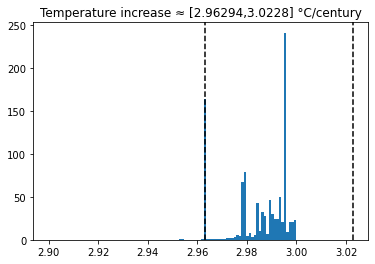

In [249]:
fig,ax = plt.subplots()
ax.hist(C*100, weights=w, density=True, bins=np.linspace(2.9,3,100))

# Find a posterior 95% confidence interval using γ_ and w
# (see section 7.4 of notes)
i = np.argsort(C)
C, w = C[i], w[i]
F = np.cumsum(w)
lo,hi = (C[F<0.025][-1], C[F>0.975][0])

ax.axvline(x=lo*100, linestyle='--', color='black')
ax.axvline(x=hi*100, linestyle='--', color='black')
ax.set_title(f"Temperature increase ≈ [{lo*100:.6},{hi*100:.6}] °C/century")

plt.show()

In [250]:
pandas.DataFrame({'w':w, 'c':C, 's':S, 'a':A, 'b1':B1, 'b2':B2}).sort_values('w', ascending=True).iloc[:5]

,w,c,s,a,b1,b2
308,4.145701e-20,0.029652,8.959014,9.472719,-0.876285,-10.016581
17745,9.164152e-20,0.030033,9.058063,10.655236,-1.207496,-9.941571
17531,2.979224e-19,0.030031,9.018779,9.565017,-0.238121,-9.968131
9857,4.362515e-19,0.029932,8.982083,9.861304,-1.197607,-10.050338
5233,4.142760e-18,0.029859,9.011452,9.465624,-0.603141,-9.999886


In [251]:
pandas.DataFrame({'w':w, 'c':C, 's':S, 'a':A, 'b1':B1, 'b2':B2}).sort_values('w', ascending=False).iloc[:5]

,w,c,s,a,b1,b2
11896,0.147571,0.029959,8.992081,9.319977,0.014311,-10.085984
26589,0.110118,0.030180,8.954927,10.695787,-1.400162,-10.131117
202,0.108573,0.029630,9.117506,9.293123,-0.131460,-10.002831
2487,0.040282,0.029789,9.053810,10.361185,-0.174079,-10.155619
2360,0.035561,0.029785,8.960896,9.453055,0.422085,-10.054121


In [ ]:
ax

In [212]:
print(logw)
print(max(logw))
print(w)

[-1204.08618792 -1262.60069584 -1236.87903099 ... -1216.81360158
 -1234.6238535  -1209.48262497]
-1156.0253875266171
[7.43398052e-41 5.61733451e-25 1.75378131e-42 ... 2.32173771e-42
 6.35073265e-19 1.49631726e-49]
